To use the database, connect to bronto.ewi.utwente.nl using these credentials:

- Username and DB name:
dab_ds2425-2a_10
- Password:
FYeq6/bll9ZFREsS
- Example command for connecting:
psql -h bronto.ewi.utwente.nl -U dab_ds2425-2a_10 dab_ds2425-2a_10

- https://bronto.ewi.utwente.nl/phppgadmin/

### Assignment 1 paper and pencil

### 1.3.3 Assignment 2: A simple ETL process to start with
Our data file for this assignment, is a spreadsheet file BI Raw Data.csv. The encoding of this file is “ISO-
8859-1”.3
A large warehouse located in the US has many customers for its different product from around the world.
The warehouse manager Mr Jack Bezos has many large customers from over the world ordering different
products from his warehouse. We follow the method of Section ?? where all steps are more or less already
given.
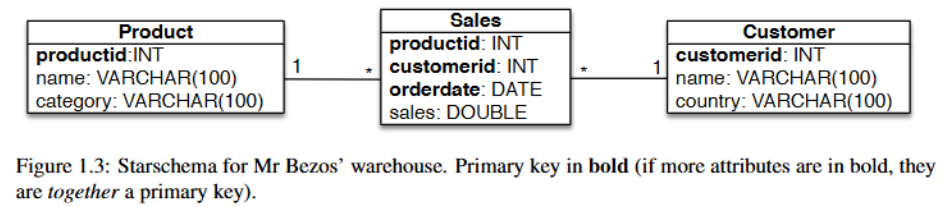

#### Step 1: Business questions (given)
Mr. Bezos wants to know answers for the following questions
- Who are his top-5 most valued customers?
- What are his top-5 most important products?

#### Step 2: Multidimensional model (given)

In [1]:
import pandas as pd
import numpy as np 
from sqlalchemy import create_engine 

In [2]:
data0=pd.read_csv('./BI_Raw_Data.csv',sep=';',encoding="ISO-8859-1")
# read first five rows of data
data0.head(5)

,Order_ID,Order_Date_Year,Order_Date_Month,Order_Date_Day,Order_Price_Total,Customer_Name,Customer_Country,Product_Name,Product_Category,Product_Order_Unit_Price,Product_Order_Quantity,Product_Order_Price_Total
0,11074,2009,9,10-9-2009,244.3,Simons bistro,Denmark,Pavlova,Confections,17.45,14,244.3
1,11075,2009,9,10-9-2009,586.0,Richter Supermarkt,Switzerland,Chang,Beverages,19.00,10,190.0
2,11075,2009,9,10-9-2009,586.0,Richter Supermarkt,Switzerland,Lakkalikööri,Beverages,18.00,2,36.0
3,11075,2009,9,10-9-2009,586.0,Richter Supermarkt,Switzerland,Spegesild,Seafood,12.00,30,360.0
4,11076,2009,9,10-9-2009,1057.0,Bon app',France,Grandma's Boysenberry Spread,Condiments,25.00,20,500.0


In [3]:
# top 5 most valued customers
grouped_customers = data0.groupby('Customer_Name')['Product_Order_Price_Total'].sum()
top5 = grouped_customers.sort_values(ascending=False)[0:5]
top5

Customer_Name
QUICK-Stop                      117483.39
Save-a-lot Markets              115673.39
Ernst Handel                    113236.68
Hungry Owl All-Night Grocers     57317.39
Rattlesnake Canyon Grocery       52245.90
Name: Product_Order_Price_Total, dtype: float64

In [4]:
# top 5 most important products
grouped_products = data0.groupby('Product_Name')['Product_Order_Price_Total'].sum()
top5_products = grouped_products.sort_values(ascending=False)[0:5]
top5_products

Product_Name
Côte de Blaye              149984.2
Thüringer Rostbratwurst     87736.4
Raclette Courdavault        76296.0
Camembert Pierrot           50286.0
Tarte au sucre              49827.9
Name: Product_Order_Price_Total, dtype: float64

#### Step 3: Data exploration --> BI_RAW_DATA_EXCEL.xlsx

#### Step 4a: Create tables in your database

In [5]:
import psycopg2

# - Username and DB name:
# dab_ds2425-2a_10
# - Password:
# FYeq6/bll9ZFREsS
# - Example command for connecting:
# psql -h bronto.ewi.utwente.nl -U dab_ds2425-2a_10 dab_ds2425-2a_10
#- https://bronto.ewi.utwente.nl/phppgadmin/


DB_HOST = "bronto.ewi.utwente.nl"
DB_NAME = "dab_ds2425-2a_10"  
DB_USER = "dab_ds2425-2a_10"       
DB_PASS = "FYeq6/bll9ZFREsS"       
DB_PORT = "5432"                # Default PostgreSQL port

# SQL queries to create tables
CREATE_TABLES_SQL = """
    CREATE TABLE IF NOT EXISTS ass2.customer (
        customerid SERIAL PRIMARY KEY,
        name VARCHAR(100),
        country VARCHAR(100)
    );

    CREATE TABLE IF NOT EXISTS ass2.product (
        productid SERIAL PRIMARY KEY,
        name VARCHAR(100),
        category VARCHAR(100)
    );

    CREATE TABLE IF NOT EXISTS ass2.sales (
        orderdate DATE NOT NULL,
        customerid INTEGER NOT NULL,
        productid INTEGER NOT NULL,
        sales DOUBLE PRECISION,
        PRIMARY KEY (orderdate, customerid, productid)
    );
"""

try:
    # Connect to PostgreSQL
    conn = psycopg2.connect(
        dbname=DB_NAME, user=DB_USER, password=DB_PASS, host=DB_HOST, port=DB_PORT
    )
    conn.autocommit = True  # Ensure changes are saved automatically

    # Create a cursor object
    cursor = conn.cursor()

    # Execute table creation queries
    cursor.execute(CREATE_TABLES_SQL)

    print("Tables created successfully.")

    # Close the cursor and connection
    cursor.close()
    conn.close()

except Exception as e:
    print("Error:", e)

Tables created successfully.


#### Step 4b: ETL — Prepare data and fill the database

In [6]:
##data0=pd.read_csv('./BI_Raw_Data.csv',sep=';',encoding="ISO-8859-1")
data0.head()

# Step-1: Select the columns related to Product such Product_Name and Product_Category
product=data0[['Product_Name', 'Product_Category']]
print(product.shape)
# Step 2: Rename the columns according to your star schema
product=product.rename(columns={'Product_Name':'name','Product_Category':'category'})
# Step 3: Remove duplicatess.
# Note ignore_index will work only for Pandas version 1.0.0 or higher.
#If it gives error do not use it or update pandas version.
product=product.drop_duplicates(ignore_index=True,keep='last')
# Step 4: Generate an identifier for the dimension
# Resetting index to be sure it starts from zero.
product['productid'] = product.reset_index().index
# Step 5: re order the columns
product=product[['productid','name','category']]
# Print the shape of data((3,77) should be printed)
print(product.shape)
#Inspect first five rows( just a sanity check)
product.head()

(2155, 2)
(77, 3)


,productid,name,category
0,0,Mishi Kobe Niku,Meat/Poultry
1,1,Sirop d'érable,Condiments
2,2,Chocolade,Confections
3,3,Røgede sild,Seafood
4,4,Valkoinen suklaa,Confections


In [7]:
customers=data0[['Customer_Name', 'Customer_Country']]
print(customers.shape)
customers=customers.rename(columns={'Customer_Name':'name','Customer_Country':'country'})
customers=customers.drop_duplicates(ignore_index=True,keep='last')
customers['customerid'] = customers.reset_index().index
customers=customers[['customerid','name','country']]
print(customers.shape)
customers.head()

(2155, 2)
(89, 3)


,customerid,name,country
0,0,La corne d'abondance,France
1,1,Spécialités du monde,France
2,2,France restauration,France
3,3,Alfreds Futterkiste,Germany
4,4,The Cracker Box,USA


In [11]:
#data0.columns

In [ ]:
#data0.columns
sales0 = data0[['Order_Date_Day', 'Customer_Name', 'Product_Name', 'Product_Order_Price_Total']]
sales = sales0.merge(customers, left_on='Customer_Name', right_on='name', how='left')
sales_final = sales.merge(product, left_on='Product_Name', right_on='name', how='left')
sales_final['Order_Date_Day'] = pd.to_datetime(sales_final['Order_Date_Day'], errors='coerce').dt.date
sales_final = sales_final[['Order_Date_Day', 'customerid', 'productid', 'Product_Order_Price_Total']]
sales_final = sales_final.rename(columns={'Order_Date_Day': 'orderdate', 'Product_Order_Price_Total': 'sales'})

# Handling missing values
sales_final = sales_final.dropna(subset=['customerid', 'productid'])

# Convert IDs to integers
sales_final['customerid'] = sales_final['customerid'].astype(int)
sales_final['productid'] = sales_final['productid'].astype(int)
print(sales_final.head())

    orderdate  customerid  productid  sales
0  2009-10-09          37         56  244.3
1  2009-10-09          82         55  190.0
2  2009-10-09          82         38   36.0
3  2009-10-09          82         23  360.0
4  2009-10-09          40         14  500.0


In [12]:
engine = create_engine(f'postgresql://{DB_NAME}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
product.to_sql('product', engine, schema='ass2', index=False, if_exists='replace')
customers.to_sql('customer', engine, schema='ass2', index=False, if_exists='replace')
sales_final.to_sql('sales', engine, schema='ass2', index=False, if_exists='replace')

155

### Step 4: Visualize ---> in dataviz.ipynb